In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_20newsgroups#引入新闻数据包
from sklearn.feature_extraction.text import TfidfVectorizer#做tfidf编码
from sklearn.feature_selection import SelectKBest, chi2#卡方检验——特征筛选
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB, BernoulliNB #引入多项式和伯努利的贝叶斯
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
###  基准模型方法
def benchmark(clf,name):
    print (u'分类器：', clf)
    
    ##  设置最优参数，并使用5折交叉验证获取最优参数值
    alpha_can = np.logspace(-2, 1, 10)
    model = GridSearchCV(clf, param_grid={'alpha': alpha_can}, cv=5)
    m = alpha_can.size
    
    ## 如果模型有一个参数是alpha，进行设置
    if hasattr(clf, 'alpha'):
        model.set_params(param_grid={'alpha': alpha_can})
        m = alpha_can.size
    ## 如果模型有一个k近邻的参数，进行设置
    if hasattr(clf, 'n_neighbors'):
        neighbors_can = np.arange(1, 15)
        model.set_params(param_grid={'n_neighbors': neighbors_can})
        m = neighbors_can.size
    ## LinearSVC最优参数配置
    if hasattr(clf, 'C'):
        C_can = np.logspace(1, 3, 3)
        model.set_params(param_grid={'C':C_can})
        m = C_can.size
    ## SVM最优参数设置
    if hasattr(clf, 'C') & hasattr(clf, 'gamma'):
        C_can = np.logspace(1, 3, 3)
        gamma_can = np.logspace(-3, 0, 3)
        model.set_params(param_grid={'C':C_can, 'gamma':gamma_can})
        m = C_can.size * gamma_can.size
    ## 设置深度相关参数，决策树
    if hasattr(clf, 'max_depth'):
        max_depth_can = np.arange(4, 10)
        model.set_params(param_grid={'max_depth': max_depth_can})
        m = max_depth_can.size
    
    ## 模型训练
    t_start = time()
    model.fit(x_train, y_train)
    t_end = time()
    t_train = (t_end - t_start) / (5*m)
    print (u'5折交叉验证的训练时间为：%.3f秒/(5*%d)=%.3f秒' % ((t_end - t_start), m, t_train))
    print (u'最优超参数为：', model.best_params_)
    
    ## 模型预测
    t_start = time()
    y_hat = model.predict(x_test)
    t_end = time()
    t_test = t_end - t_start
    print (u'测试时间：%.3f秒' % t_test)
    
    ## 模型效果评估
    train_acc = metrics.accuracy_score(y_train, model.predict(x_train))
    test_acc = metrics.accuracy_score(y_test, y_hat)
    print (u'训练集准确率：%.2f%%' % (100 * train_acc))
    print (u'测试集准确率：%.2f%%' % (100 * test_acc))
    
    ## 返回结果(训练时间耗时，预测数据耗时，训练数据错误率，测试数据错误率, 名称)
    return t_train, t_test, 1-train_acc, 1-test_acc, name

In [3]:
## 设置属性防止中文乱码
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
### 数据加载
print (u'加载数据...')
t_start = time()
## 不要头部信息
remove = ('headers', 'footers', 'quotes')
## 只要这四类数据
categories = 'alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'

## 分别加载训练数据和测试数据
data_train = fetch_20newsgroups(data_home='./datas/',subset='train', categories=categories, shuffle=True, random_state=0, remove=remove)
data_test = fetch_20newsgroups(data_home='./datas/',subset='test', categories=categories, shuffle=True, random_state=0, remove=remove)

## 完成
print (u"完成数据加载过程.耗时:%.3fs" % (time() - t_start))

加载数据...
完成数据加载过程.耗时:5.247s


In [5]:
print(data_train.target_names)

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [6]:
### 获取加载数据的相关信息
def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6

categories = data_train.target_names
data_train_size_mb = size_mb(data_train.data)
data_test_size_mb = size_mb(data_test.data)

print (u'数据类型：', type(data_train.data))
print("%d文本数量 - %0.3fMB (训练数据集)" % (len(data_train.data), data_train_size_mb))
print("%d文本数量 - %0.3fMB (测试数据集)" % (len(data_test.data), data_test_size_mb))
print (u'训练集和测试集使用的%d个类别的名称：' % len(categories))
print(categories)

数据类型： <class 'list'>
2034文本数量 - 2.428MB (训练数据集)
1353文本数量 - 1.800MB (测试数据集)
训练集和测试集使用的4个类别的名称：
['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [7]:
### 数据重命名
x_train = data_train.data
y_train = data_train.target
x_test = data_test.data
y_test = data_test.target

In [8]:
### 输出前5个样本
print (u' -- 前5个文本 -- ')
for i in range(5):
    print (u'文本%d(属于类别 - %s)：' % (i+1, categories[y_train[i]]))
    print (x_train[i])
    print ('\n\n')

 -- 前5个文本 -- 
文本1(属于类别 - alt.atheism)：
If one is a vegan (a vegetarian taht eats no animal products at at i.e eggs, 
milk, cheese, etc., after about 3 years of a vegan diet, you need to start 
taking B12 supplements because b12 is found only in animals.) Acutally our 
bodies make B12, I think, but our bodies use up our own B12 after 2 or 3 
years.  
Lacto-oveo vegetarians, like myself, still get B12 through milk products 
and eggs, so we don't need supplements.
And If anyone knows more, PLEASE post it.  I'm nearly contridicting myself 
with the mish-mash of knowledge I've gleaned.



文本2(属于类别 - comp.graphics)：
Hi,
         I have a friend who is working on 2-d and 3-d object recognition. He is looking
for references describing algorithms on the following subject areas:

Thresholding
Edge Segmentation
Marr-Hildreth
Sobel Operator
Chain Codes
Thinning - Skeletonising

If anybody is willing to post an algorithm that they have implemented which demonstrates
any of the above topics, it woul

In [9]:
### 文档转换为向量
## 转换
# 要求输入的数据类型必须是list，list中的每条数据，单词是以空格分割开的
vectorizer = TfidfVectorizer(input='content', stop_words='english', max_df=0.5, sublinear_tf=True)
x_train = vectorizer.fit_transform(data_train.data)  # x_train是稀疏的，scipy.sparse.csr.csr_matrix
x_test = vectorizer.transform(data_test.data)
print (u'训练集样本个数：%d，特征个数：%d' % x_train.shape)
print (u'停止词:\n')
print(vectorizer.get_stop_words())
## 获取最终的特征属性名称
feature_names = np.asarray(vectorizer.get_feature_names())

C:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


训练集样本个数：2034，特征个数：26576
停止词:

frozenset({'against', 'are', 'again', 'only', 'show', 'few', 'where', 'thru', 'get', 'between', 'this', 'besides', 'couldnt', 'everywhere', 'here', 'etc', 'hereupon', 'other', 'system', 'such', 'us', 'these', 'mill', 'will', 'thereafter', 'which', 'whenever', 'why', 'due', 'beforehand', 'can', 'at', 'up', 'side', 'wherever', 'twelve', 'afterwards', 'via', 'our', 'thin', 'down', 'move', 'behind', 'meanwhile', 'one', 'whereby', 'during', 'further', 'below', 'had', 'whose', 'ever', 'its', 'nothing', 'much', 'take', 'seems', 'what', 'should', 'almost', 'wherein', 'has', 'part', 'ie', 'whom', 'for', 'name', 'who', 'him', 'were', 'she', 'yourself', 'still', 'am', 'seeming', 'throughout', 'may', 'once', 'across', 'forty', 'over', 'then', 'anyone', 'toward', 'otherwise', 'latter', 'another', 'after', 'back', 'cant', 'cry', 'hers', 'or', 'sometimes', 'whoever', 'sometime', 'amount', 'mine', 'none', 'empty', 'above', 'latterly', 'to', 'beside', 'fill', 'four', 'migh

In [15]:
## 特征选择
ch2 = SelectKBest(chi2, k=1000)
x_train = ch2.fit_transform(x_train, y_train)
x_test = ch2.transform(x_test)
feature_names = [feature_names[i] for i in ch2.get_support(indices=True)]

C:\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [11]:
### 使用不同的分类器对数据进行比较
print (u'分类器的比较：\n')
clfs = [
    [RidgeClassifier(), 'Ridge'],
    [KNeighborsClassifier(), 'KNN'],
    [MultinomialNB(), 'MultinomialNB'],
    [BernoulliNB(), 'BernoulliNB'],
    [RandomForestClassifier(n_estimators=200), 'RandomForest'],
    [SVC(), 'SVM'],
    [LinearSVC(loss='squared_hinge', penalty='l1', dual=False, tol=1e-4), 'LinearSVC-l1'],
    [LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-4), 'LinearSVC-l2']
]

## 将训练数据保存到一个列表中
result = []
for clf,name in clfs:
    # 计算算法结果
    a = benchmark(clf,name)
    # 追加到一个列表中，方便进行展示操作
    result.append(a)
    print ('\n')
## 将列表转换为数组
result = np.array(result)

分类器的比较：

分类器： RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)
5折交叉验证的训练时间为：8.090秒/(5*10)=0.162秒
最优超参数为： {'alpha': 0.46415888336127775}
测试时间：0.001秒
训练集准确率：92.63%
测试集准确率：75.76%


分类器： KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
5折交叉验证的训练时间为：10.944秒/(5*14)=0.156秒
最优超参数为： {'n_neighbors': 1}
测试时间：0.086秒
训练集准确率：96.51%
测试集准确率：50.55%


分类器： MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.569秒/(5*10)=0.011秒
最优超参数为： {'alpha': 0.01}
测试时间：0.001秒
训练集准确率：91.40%
测试集准确率：76.72%


分类器： BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
5折交叉验证的训练时间为：0.468秒/(5*10)=0.009秒
最优超参数为： {'alpha': 0.01}
测试时间：0.001秒
训练集准确率：88.64%
测试集准确率：74.28%


分类器： RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
     

In [12]:
### 获取需要画图的数据
result = [[x[i] for x in result] for i in range(5)]
training_time, test_time, training_err, test_err, clf_names = result

training_time = np.array(training_time).astype(np.float)
test_time = np.array(test_time).astype(np.float)
training_err = np.array(training_err).astype(np.float)
test_err = np.array(test_err).astype(np.float)

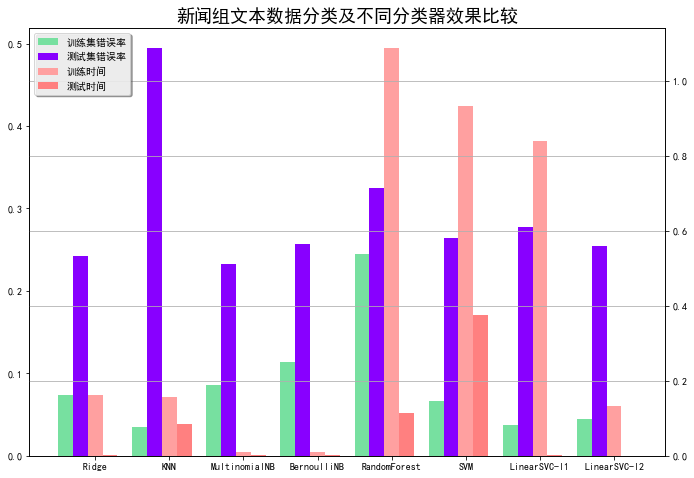

In [13]:
### 画图
x = np.arange(len(training_time))
plt.figure(figsize=(10, 7), facecolor='w')
ax = plt.axes()
b0 = ax.bar(x+0.1, training_err, width=0.2, color='#77E0A0')
b1 = ax.bar(x+0.3, test_err, width=0.2, color='#8800FF')
ax2 = ax.twinx()
b2 = ax2.bar(x+0.5, training_time, width=0.2, color='#FFA0A0')
b3 = ax2.bar(x+0.7, test_time, width=0.2, color='#FF8080')
plt.xticks(x+0.5, clf_names)
plt.legend([b0[0], b1[0], b2[0], b3[0]], (u'训练集错误率', u'测试集错误率', u'训练时间', u'测试时间'), loc='upper left', shadow=True)
plt.title(u'新闻组文本数据分类及不同分类器效果比较', fontsize=18)
plt.xlabel(u'分类器名称')
plt.grid(True)
plt.tight_layout(2)
plt.show()